<h2>Assignment3</h2> - mini term project
<h3>Using Camera to detect Heartbeat</h3>
- 2017572003 Jaeyung Lee
- 2017572026 Juyeon Moon

In [209]:
# Load all library
import os
import skvideo.io
import skvideo.datasets
import numpy as np
from scipy import signal
from scipy import interpolate
import matplotlib.pyplot as plt
import pandas as pd
import collections

# Brightness signal computation
- we caculate brightness signal follow below formula

$$b[n] = \frac{1}{W*H}\displaystyle \sum_{x}^H \displaystyle \sum_{y}^W v[n,x,y,1]$$

* W: width of the image in pixels
* H: height of the image in pixels
* v [n, x, y, 1] : light level of the red plane (index 1) at [x, y] coordinates of frame n in the video signal

In [210]:
def brightness_signal(foldername):
    bright_d = collections.OrderedDict()
    fig = plt.figure(figsize=(20,15))
    for index, j in enumerate(os.listdir(foldername)):
        # Read Video at grayscale
        videodata = skvideo.io.vread(foldername+"\\"+j, outputdict={"-pix_fmt": "gray"})
        brightness = np.zeros((len(videodata)))
        for i in range(len(videodata)):
            frame = videodata[i]
            brightness[i] = sum(frame) / (frame.shape[0] * frame.shape[1])

        '''
        cutting 40 seconds ==> 40 seconds * 30fpb = 1200
        '''
        brightness = brightness[-1200:]
        bright_d[j] = brightness
        ax1 = fig.add_subplot(4,1,index+1)
        # plt.figure(figsize=(20,5))
        ax1.plot(list(range(len(brightness))), brightness)
        plt.title(j)
        
    plt.show()
    return bright_d

* Jaeyung's normal heartbeat brightness signal<br>
* Juyeon's normal & exercise heartbeat brightness signal

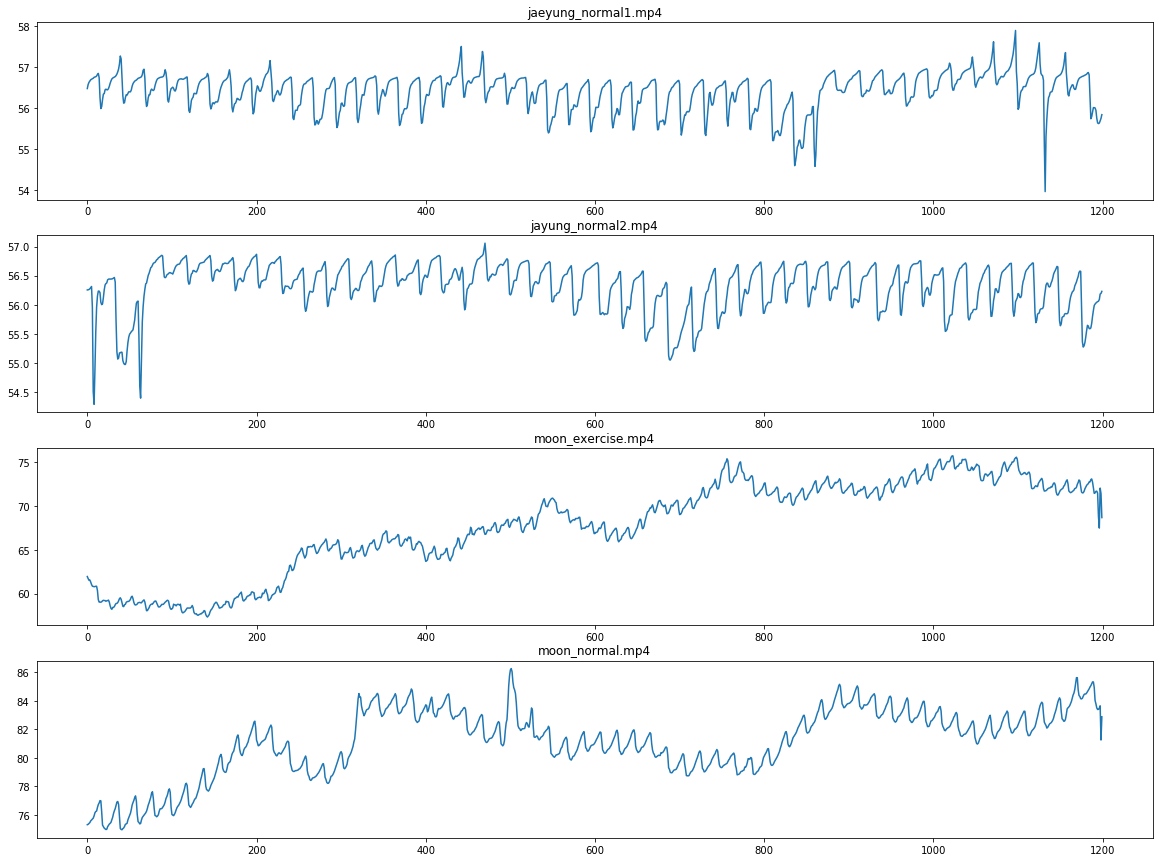

In [211]:
#just input your folder name
all_bright = brightness_signal("beat")

# Band-pass filtering
- I think my first video is nice. So, i use it:)

In [212]:
def Bandpass_filter(dict):
    BPM_L = 45;    # Heart rate lower limit [bpm]
    BPM_H = 200;   # Heart rate higher limit [bpm]
    frame_rate = 30
    fig = plt.figure(figsize=(20,15))
    band = collections.OrderedDict()

    # Butterworth frequencies must be in [0, 1], where 1 corresponds to half the sampling rate
    b, a = signal.butter(4, [((BPM_L / 60) / frame_rate * 2), ((BPM_H / 60) / frame_rate * 2)], 'bandpass')
    for index, data in enumerate(dict):
        filter_bright = signal.lfilter(b, a, dict[data])
        ax1 = fig.add_subplot(4,1,index+1)
        ax1.plot(list(range(len(filter_bright))), filter_bright)
        plt.title(data)
        band[data] = filter_bright
    plt.show()
    return band

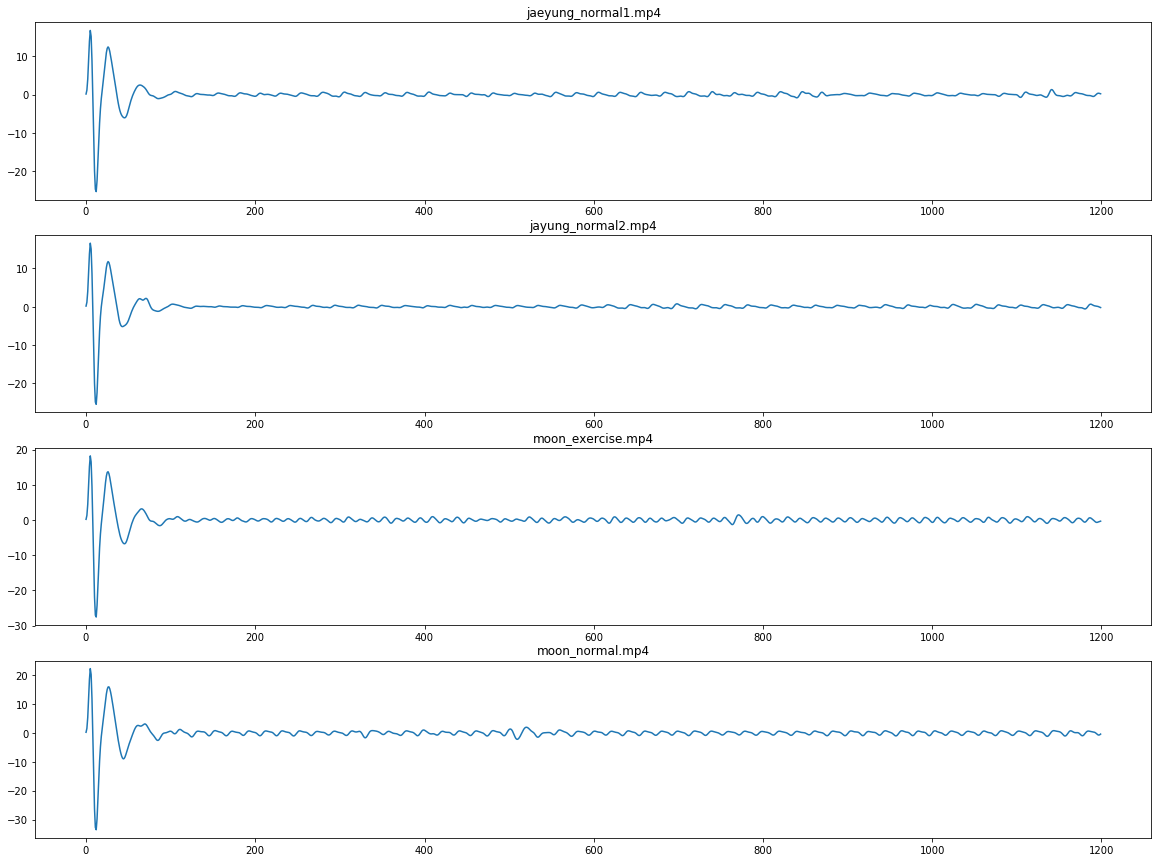

In [213]:
band = Bandpass_filter(all_bright)

# Smoothing
* because front 100 dataset looks like noise, so we remove it

In [214]:
def smoothing(dict):
    N = 5
    smooth = collections.OrderedDict()
    for index, data in enumerate(dict):
        smooth_signal = pd.rolling_mean(dict[data], N)[N-1:]
        fig = plt.figure(figsize=(20,15))
        ax1 = fig.add_subplot(4,1,index+1)
        # Here is remove code smooth_signal[100:]
        after, = plt.plot(list(range(len(smooth_signal[100:]))), smooth_signal[100:], label="After smoothing")
        before, = plt.plot(list(range(len(filter_bright[100+N-1:]))), filter_bright[100+N-1:], 'r', label="Before smoothing")
        plt.title(data)
        plt.legend(handles=[after, before], fontsize="x-large", loc=2)
        plt.show()
        smooth[data] = smooth_signal[100:]
    return smooth

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version
  """


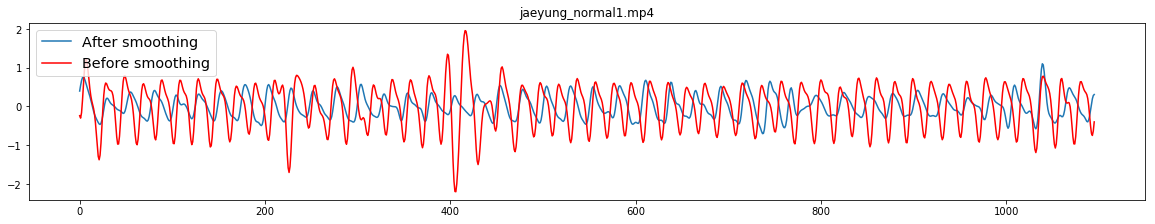

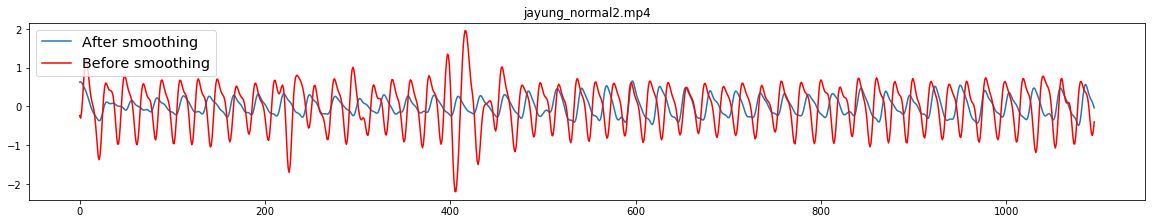

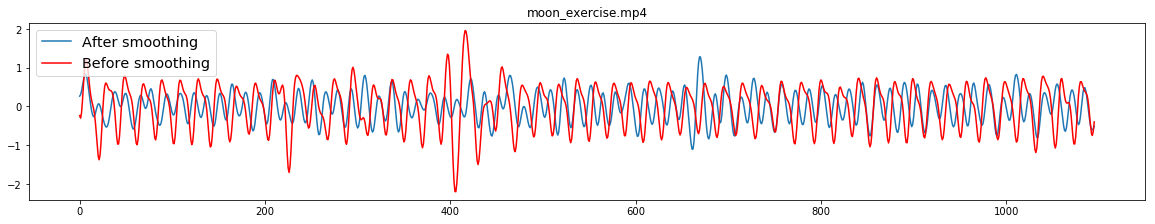

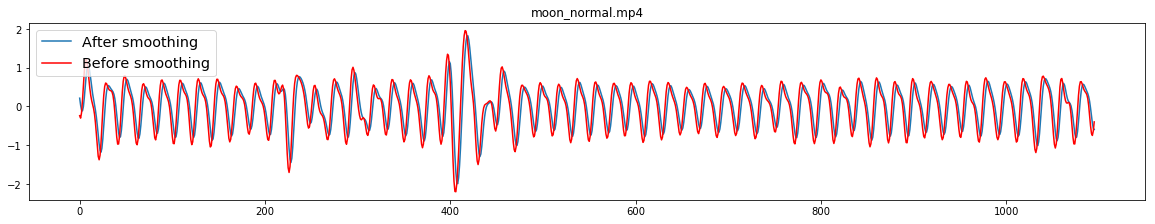

In [215]:
smooth = smoothing(band)

# Upsampling & Interpolation

In [216]:
def up_inter(dict):
    up_inter_d = collections.OrderedDict()
    fig = plt.figure(figsize=(20, 15))
    for index, data in enumerate(dict):
        re_signal = signal.resample(dict[data], 1200 * 6)
        cubic = pd.Series(re_signal)
        cubic.interpolate(method='cubic')
        ax1 = fig.add_subplot(4,1,index+1)
        plt.title(data)
        plt.plot(list(range(len(cubic))), cubic)
        up_inter_d[data] = cubic
        
    plt.show()
    return up_inter_d

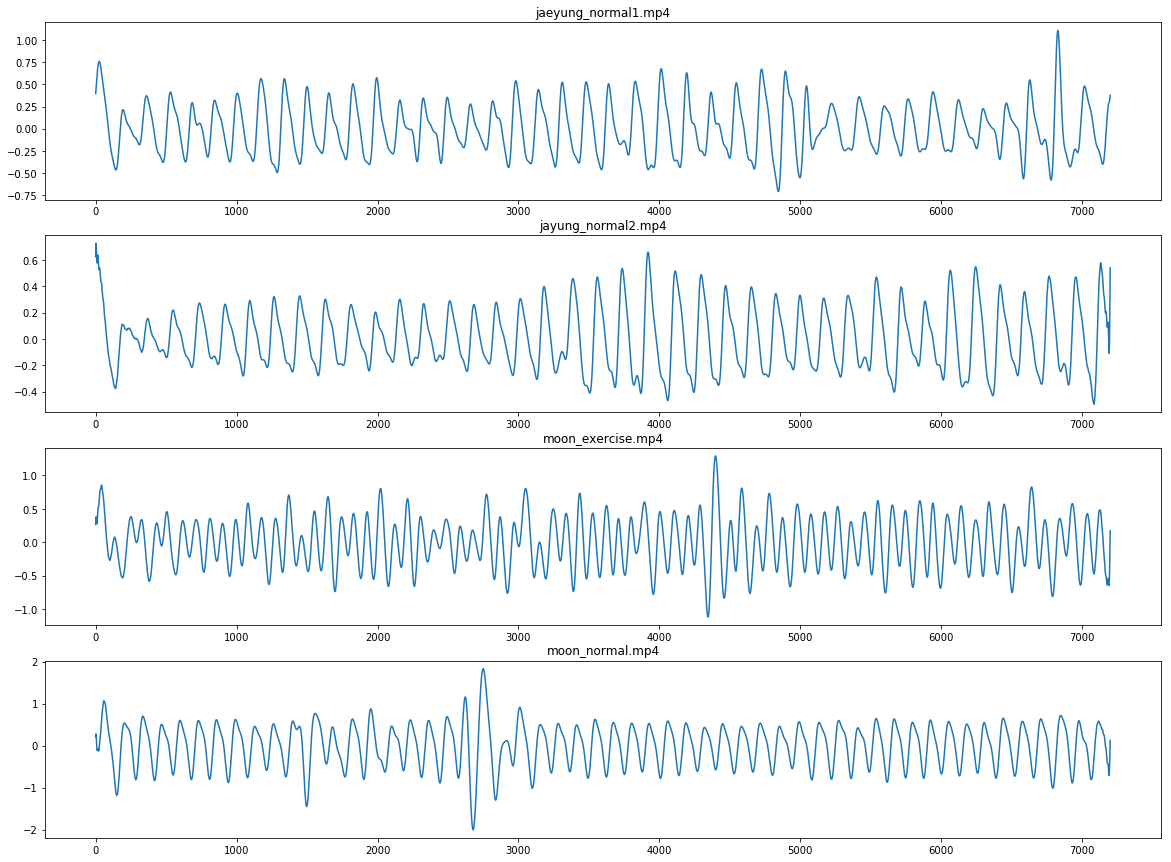

In [217]:
after_up_inter = up_inter(smooth)

# Peak Detection

In [218]:
def lets_find_peak(dict):
    fig = plt.figure(figsize=(20, 15))
    for index, data in enumerate(dict):
        peak = signal.find_peaks_cwt(dict[data], np.arange(1,100))
        peak_y = []
        # print(a_tck)
        for i in peak:
            peak_y.append(dict[data][i])
        ax1 = fig.add_subplot(4,1,index+1)
        plt.title(data)
        plt.plot(list(range(len(dict[data]))), dict[data], peak, peak_y, 'ro')
    plt.show()

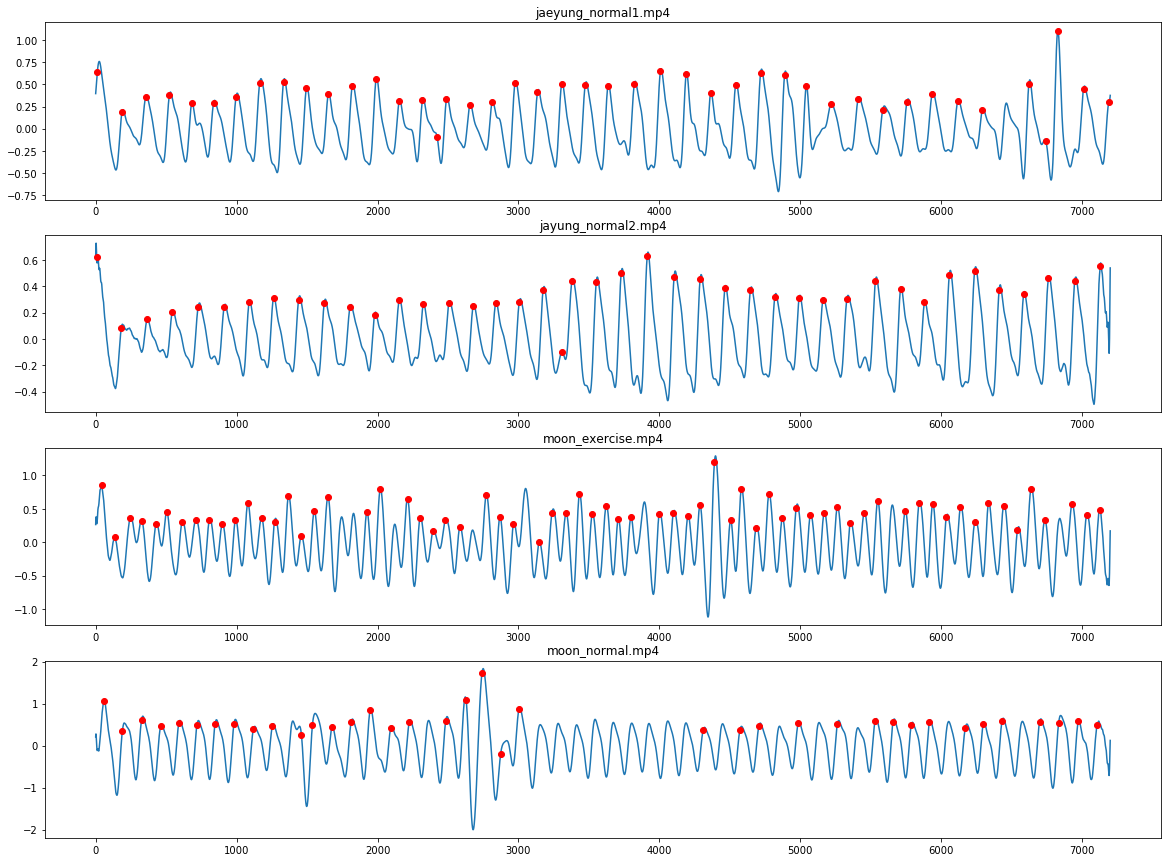

In [219]:
lets_find_peak(after_up_inter)

## Compare Before & After upsample & interpolate signal

In [238]:
def lets_find_peak_20(dict, cutting):
    fig = plt.figure(figsize=(20, 15))
    new_dict = {}
    for index, data in enumerate(dict):
        if(data.find("jaeyung_before") == 0):
            cutting = cutting
            p_range = 10
        else:
            cutting = cutting * 6
            p_range = 100
            
        new_dict[data] = dict[data][:cutting]
        peak = signal.find_peaks_cwt(new_dict[data], np.arange(1,p_range))
        peak_y = []
        # print(a_tck)
        for i in peak:
            peak_y.append(new_dict[data][i])
        ax1 = fig.add_subplot(4,1,index+1)
        plt.title(data)
        plt.plot(list(range(len(new_dict[data]))), new_dict[data], peak, peak_y, 'ro')
    plt.show()

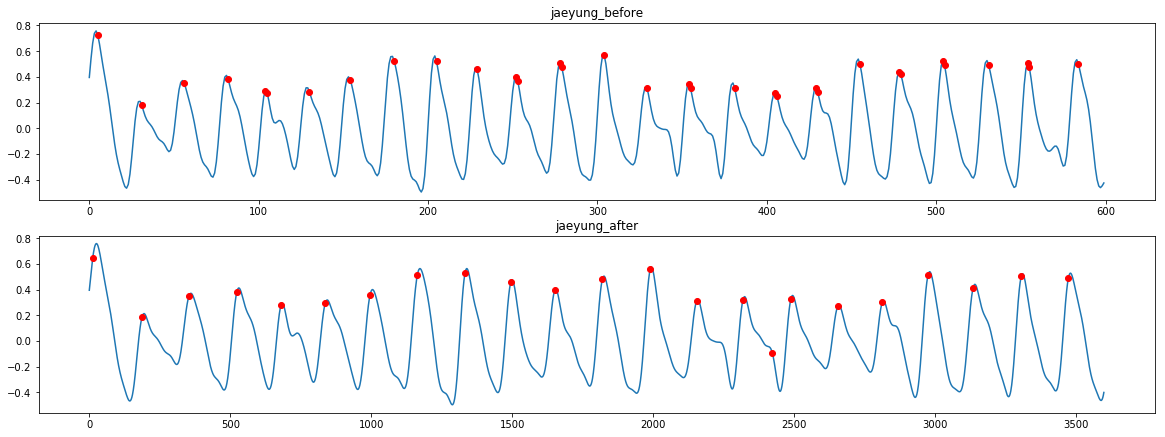

In [239]:
input_dict = {}
input_dict["jaeyung_before"] = smooth["jaeyung_normal1.mp4"]
input_dict["jaeyung_after"] = after_up_inter["jaeyung_normal1.mp4"]

lets_find_peak_20(input_dict, 600)

## Suppose after upsampled and interpolated dataset more correctly